In [1]:
from cal_ind_indicator import IndustryMetricsCalculator
import pandas as pd

# 1) 初始化（路径替换为你的本地文件）
calculator = IndustryMetricsCalculator(
        basicinfo_path='basicinfo.pkl',
        balsheet_path='balsheet.pkl',
        cf_path='cf.pkl',
        profit_path='profit.pkl',
        sw_ind_level2_path='SW_IND_LEVEL2_NEW.pkl',
        start_year=2008
    )

In [21]:
def get_single_industry_series(calculator, industry_name, expr="weighted_mean(ROE, ASSET)"):
    """
    计算单个二级行业的指标走势 (例: '种植业')

    参数
    ----
    calculator : IndustryMetricsCalculator 实例
    industry_name : str   中文行业名 (如 "种植业")
    expr : str            指标表达式 (默认 weighted_mean(ROE, ASSET))

    返回
    ----
    pd.Series : 行业时间序列
    """
    # === 行业映射表 ===
    ind_map_df = pd.read_excel("SW_Level2_Industry_Mapping_Full.xlsx")
    name2code = dict(zip(ind_map_df["INDUSTRYNAME"], ind_map_df["INDUSTRYCODE"].astype(str)))

    if industry_name not in name2code:
        raise ValueError(f"行业 {industry_name} 未找到，请检查映射表")

    industry_code = name2code[industry_name]

    # === 获取基本数据 ===
    ROE = calculator.get_stock_data(
        expression="ROE=NETPROFIT/PARESHARRIGH", calc_type="ttm", PIT=True, freq="M"
    )["ROE"]
    ASSET = calculator.get_stock_data(
        expression="TOTASSET=TOTASSET", calc_type="quarter", PIT=True, freq="M"
    )["TOTASSET"]

    # === 获取行业成分股 ===
    sw = pd.read_pickle("SW_IND_LEVEL2_NEW.pkl")
    symbols = sw.loc[sw["INDUSTRYCODE"].astype(str) == industry_code, "SYMBOL"].astype(str).tolist()

    # === 过滤有效股票 ===
    valid = set(symbols) & set(ROE.index.get_level_values(1)) & set(ASSET.index.get_level_values(1))
    if not valid:
        raise ValueError(f"{industry_name} ({industry_code}) 无可用股票数据")

    # === 自己算加权ROE ===
    roe = ROE.loc[(slice(None), list(valid))].unstack()
    asset = ASSET.loc[(slice(None), list(valid))].unstack()

    series = (roe * asset).sum(axis=1) / asset.sum(axis=1)
    series.name = f"{industry_name}-{expr}"

    return series

Field 'NETPROFIT' found in multiple tables ['cf', 'profit']. Using table 'profit' with least NaNs (26 NaNs).
Using cached data for field '('ttm', 'PIT', True, 'M', 'NETPROFIT')'.
Using cached data for field '('ttm', 'PIT', True, 'M', 'PARESHARRIGH')'.
Using cached data for field '('quarter', 'PIT', True, 'M', 'TOTASSET')'.
Field 'NETPROFIT' found in multiple tables ['cf', 'profit']. Using table 'profit' with least NaNs (26 NaNs).
Using cached data for field '('ttm', 'PIT', True, 'M', 'NETPROFIT')'.
Using cached data for field '('ttm', 'PIT', True, 'M', 'PARESHARRIGH')'.
Using cached data for field '('quarter', 'PIT', True, 'M', 'TOTASSET')'.
Field 'NETPROFIT' found in multiple tables ['cf', 'profit']. Using table 'profit' with least NaNs (26 NaNs).
Using cached data for field '('ttm', 'PIT', True, 'M', 'NETPROFIT')'.
Using cached data for field '('ttm', 'PIT', True, 'M', 'PARESHARRIGH')'.
Using cached data for field '('quarter', 'PIT', True, 'M', 'TOTASSET')'.
Field 'NETPROFIT' found i

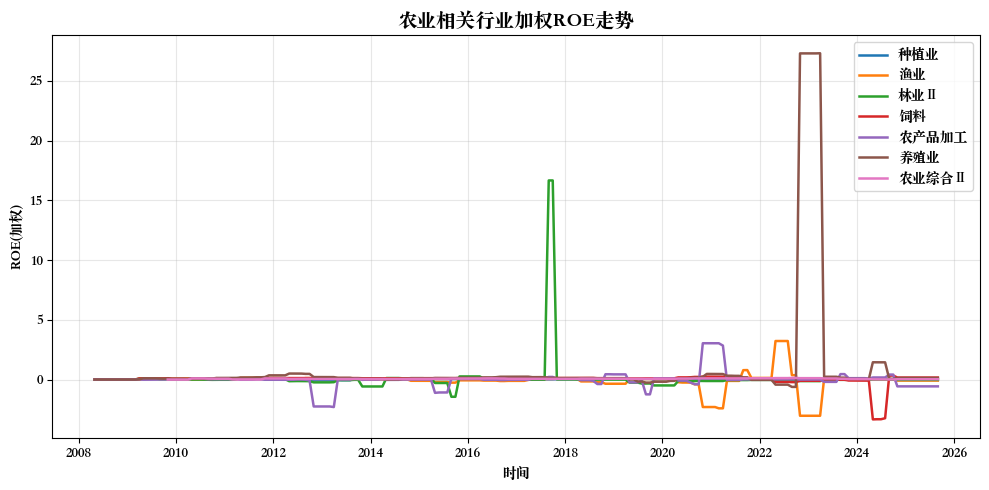

In [23]:
import matplotlib.pyplot as plt
agri_list = ["种植业", "渔业", "林业Ⅱ", "饲料", "农产品加工", "养殖业", "农业综合Ⅱ"]

series_dict = {}
for ind in agri_list:
    try:
        s = get_single_industry_series(calculator, ind)
        series_dict[ind] = s
    except Exception as e:
        print(f"[WARN] {ind} 计算失败: {e}")

df_agri = pd.DataFrame(series_dict).sort_index()

# === 画折线图 ===
plt.figure(figsize=(10, 5))
for col in df_agri.columns:
    plt.plot(df_agri.index, df_agri[col], label=col, lw=1.8)

plt.title("农业相关行业加权ROE走势", fontsize=14)
plt.xlabel("时间")
plt.ylabel("ROE(加权)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [2]:
TEST_DATA = calculator.get_stock_data(
    expression='TOTLIAB + BIZCASHINFL + NETPROFIT',
    calc_type='quarter',
    PIT=True,
    field_table_map={'NETPROFIT': 'profit'}
)
# Display the first few rows of the resulting DataFrame
TEST_DATA.head()

/Users/tiancaixiaohuoban/Desktop/实习/卖方实习/天风证券实习（金工RS）/主观+量化（保险）/cal_ind_indicator.py:153: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_list = pd.date_range(start=str(self.start_year) + '-01-01', end=today, freq=freq)


Using table 'profit' for field 'NETPROFIT'.


BIZCASHINFL       TOTLIAB     NETPROFIT        metric
           SYMBOL                                                        
2008-04-30 000002  1.029951e+10  7.058038e+10  7.417298e+08  8.162163e+10
           000004  1.679469e+07  7.276973e+07 -4.549203e+05  8.910950e+07
           000005  2.146178e+07  7.224674e+08  2.261319e+06  7.461905e+08
           000006  5.454942e+07  3.688716e+09  2.295101e+08  3.972775e+09
           000007  5.743033e+07  7.399906e+08 -1.108648e+07  7.863345e+08

In [3]:
# 个股层面的 ROE（TTM）
ROE = calculator.get_stock_data(
    expression='ROE=NETPROFIT/PARESHARRIGH',
    calc_type='ttm',
    PIT=True,
)
ROE.head()

Field 'NETPROFIT' found in multiple tables ['cf', 'profit']. Using table 'profit' with least NaNs (26 NaNs).


/Users/tiancaixiaohuoban/Desktop/实习/卖方实习/天风证券实习（金工RS）/主观+量化（保险）/cal_ind_indicator.py:153: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_list = pd.date_range(start=str(self.start_year) + '-01-01', end=today, freq=freq)


NETPROFIT  PARESHARRIGH       ROE
           SYMBOL                                      
2009-01-31 002014  7.036111e+07  5.865218e+08  0.119963
           600325  6.452264e+08  3.940042e+09  0.163761
           600435  1.642765e+08  6.390653e+08  0.257057
           600516  6.208679e+08  1.817868e+09  0.341536
           600558  5.861212e+07  6.590211e+08  0.088938

In [4]:
# 个股层面的净利润（TTM）
NETPROFIT = calculator.get_stock_data(
    expression='NETPROFIT=NETPROFIT',
    calc_type='ttm',
    PIT=True,
)
NETPROFIT.head()

Field 'NETPROFIT' found in multiple tables ['cf', 'profit']. Using table 'profit' with least NaNs (26 NaNs).
Using cached data for field '('ttm', 'PIT', True, 'M', 'NETPROFIT')'.


/Users/tiancaixiaohuoban/Desktop/实习/卖方实习/天风证券实习（金工RS）/主观+量化（保险）/cal_ind_indicator.py:153: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_list = pd.date_range(start=str(self.start_year) + '-01-01', end=today, freq=freq)


NETPROFIT
           SYMBOL              
2009-01-31 002014  7.036111e+07
           600325  6.452264e+08
           600435  1.642765e+08
           600516  6.208679e+08
           600558  5.861212e+07

In [5]:
ASSET = calculator.get_stock_data(
        expression='TOTASSET=TOTASSET',
        calc_type='quarter',
        PIT=True,
    )

roe_weight = calculator.get_industry_indicator(
    expression='weighted_mean(ROE, ASSET)',
    industry='110100',
    ROE=ROE['ROE'],
    ASSET=ASSET['TOTASSET']
)
roe_weight.head()

/Users/tiancaixiaohuoban/Desktop/实习/卖方实习/天风证券实习（金工RS）/主观+量化（保险）/cal_ind_indicator.py:153: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_list = pd.date_range(start=str(self.start_year) + '-01-01', end=today, freq=freq)


,Metric
2008-04-30,0.0
2008-05-31,0.0
2008-06-30,0.0
2008-07-31,0.0
2008-08-31,0.0


In [10]:
from pathlib import Path
import numpy as np
# ======================== CONFIG ========================
MIN_NAMES   = 15
OUTDIR      = Path("outputs_industry"); OUTDIR.mkdir(exist_ok=True)
DATE_START  = "2008-01-01"
DATE_END    = None

# 是否运行极简回测（不需要就置 False）
RUN_BACKTEST = True
TOPK         = 10
COST_BP      = 0     # 单位：bp
COST         = COST_BP / 10000.0

# ======================== I/O & 工具函数 ========================
def load_wind_prices():
    """读取日度个股收盘价，转成月末宽表（ME），时间裁剪。"""
    cand = []
    if Path("AShareEODPrices_300_500_1000.pkl").exists():
        cand.append("AShareEODPrices_300_500_1000.pkl")
    cand += [p for p in ["AShareEODPrices.pkl", "AShareEODPrices.parquet", "AShareEODPrices.csv"] if Path(p).exists()]
    if not cand:
        raise FileNotFoundError("未找到 AShareEODPrices*.pkl / .parquet / .csv")

    src = cand[0]
    if src.endswith(".pkl"):
        df = pd.read_pickle(src)
    elif src.endswith(".parquet"):
        df = pd.read_parquet(src)
    else:
        df = pd.read_csv(src)

    need_cols = ["TRADE_DT", "S_INFO_WINDCODE", "S_DQ_CLOSE"]
    miss = [c for c in need_cols if c not in df.columns]
    if miss:
        raise ValueError(f"{src} 缺少列: {miss}，需包含 {need_cols}")

    df["TRADE_DT"] = pd.to_datetime(df["TRADE_DT"], format="%Y%m%d", errors="coerce")
    df = df.dropna(subset=["TRADE_DT"]).sort_values("TRADE_DT")
    if DATE_START:
        df = df[df["TRADE_DT"] >= pd.to_datetime(DATE_START)]
    if DATE_END:
        df = df[df["TRADE_DT"] <= pd.to_datetime(DATE_END)]

    wide = df.pivot_table(index="TRADE_DT", columns="S_INFO_WINDCODE",
                          values="S_DQ_CLOSE", aggfunc="last")
    prices_m = wide.resample("ME").last().dropna(how="all")
    return prices_m

def normalize_industry_symbols():
    """
    标准化行业-股票映射：
    - 自动识别行业列：IND_NAME / INDUSTRYNAME / INDUSTRYCODE → 统一命名为 INDUSTRY
    - SYMBOL 从 6位券码映射到 Wind 代码（AshareDescription.pkl 提供）
    返回：包含列 ['INDUSTRY','SYMBOL',...行业中文名列(若有)] 的 DataFrame
    """
    sw = pd.read_pickle("SW_IND_LEVEL2_NEW.pkl").reset_index(drop=False)
    desc = pd.read_pickle("AshareDescription.pkl")

    if "IND_NAME" in sw.columns:
        ind_col = "IND_NAME"
    elif "INDUSTRYNAME" in sw.columns:
        ind_col = "INDUSTRYNAME"
    else:
        ind_col = "INDUSTRYCODE"

    code_map = dict(zip(desc["S_INFO_CODE"].astype(str).str.zfill(6),
                        desc["S_INFO_WINDCODE"]))
    sw["SYMBOL"] = sw["SYMBOL"].astype(str).str.zfill(6).map(code_map)
    sw = sw.dropna(subset=["SYMBOL", ind_col])
    sw = sw.rename(columns={ind_col: "INDUSTRY"})
    return sw

def winsorize_z(row: pd.Series, l=0.01, u=0.99) -> pd.Series:
    """行内去极值 + 标准化，得到横截面Z分。"""
    ql, qu = row.quantile(l), row.quantile(u)
    r = row.clip(ql, qu)
    std = r.std(ddof=0)
    return (r - r.mean()) / (std if std != 0 else 1.0)

# ======================== 核心：行业ROE(加权) ========================
def compute_industry_roe_weighted(calc, industries, monthly_idx):
    """
    计算行业 ROE（按总资产加权）：
    ROE = NETPROFIT / PARESHARRIGH（TTM, PIT, 月频）
    ASSET = TOTASSET（季频时点, PIT, 月频对齐）
    行业层面用 weighted_mean(ROE, ASSET)
    """
    ROE = calc.get_stock_data(
        expression="ROE=NETPROFIT/PARESHARRIGH", calc_type="ttm", PIT=True, freq="M"
    )["ROE"]
    ASSET = calc.get_stock_data(
        expression="TOTASSET=TOTASSET", calc_type="quarter", PIT=True, freq="M"
    )["TOTASSET"]

    out = {}
    for ind in industries:
        try:
            s = calc.get_industry_indicator(
                expression="weighted_mean(ROE, ASSET)",
                industry=ind, ROE=ROE, ASSET=ASSET
            )["Metric"]
            out[ind] = s
        except Exception:
            # 样本不足或字段缺失的行业直接跳过
            pass

    df = pd.DataFrame(out).sort_index().resample("ME").last()
    return df.reindex(monthly_idx)

# ======================== 极简回测（可选） ========================
def build_equal_weight_next_month_returns(prices_m, groups, industries):
    """
    由月末价格计算“下月行业等权收益”面板 ind_ret：
    ind_ret[ind] = 次月个股收益的等权均值（仅统计行业成分中存在于价格列的股票）
    """
    rets_next = prices_m.pct_change(fill_method=None).shift(-1)  # 当月信号→次月收益
    avail_syms = set(prices_m.columns)
    tmp = {}
    for ind in industries:
        names = [n for n in groups.get(ind, []) if n in avail_syms]
        if len(names) >= MIN_NAMES:
            tmp[ind] = rets_next[names].mean(axis=1)
    ind_ret = pd.DataFrame(tmp).sort_index()  # 已是月频
    return ind_ret

def backtest_equal_topk(SCORE, ind_ret, topk, cost=COST):
    """
    以 SCORE（date×industry）为信号，月度等权选 Top-K 行业，
    交易成本=权重变动的一次交易成本和 * cost。
    返回：组合净值、简表、月度组合收益序列。
    """
    SCORE, ind_ret = SCORE.align(ind_ret, join="inner", axis=1)

    def _pick_equal_topk(row, k=topk):
        row = row.dropna()
        w = pd.Series(0.0, index=SCORE.columns)
        if not row.empty:
            top = row.nlargest(k).index
            w.loc[top] = 1.0 / len(top)
        return w

    weights = SCORE.apply(_pick_equal_topk, axis=1)
    w_prev = pd.Series(0.0, index=SCORE.columns)
    port_rets = []
    for dt in weights.index:
        if dt not in ind_ret.index:
            port_rets.append(np.nan); continue
        w_now = weights.loc[dt].fillna(0.0)
        gross = float((w_now * ind_ret.loc[dt]).sum())
        turnover = (w_now - w_prev).abs().sum()
        port_rets.append(gross - turnover * cost)
        w_prev = w_now

    port_rets = pd.Series(port_rets, index=weights.index, name="port_rets").dropna()
    nav = (1 + port_rets).cumprod()
    # 简要绩效
    ann_ret = (1 + port_rets.mean())**12 - 1
    ann_vol = port_rets.std(ddof=0) * (12**0.5)
    sharpe  = np.nan if ann_vol == 0 else (port_rets.mean()*12) / ann_vol
    summary = pd.DataFrame({"年化收益":[ann_ret], "年化波动":[ann_vol], "夏普":[sharpe]})
    return nav, summary, port_rets

# ======================== 年度/YTD/总计 绩效表 ========================
def _one_period_table_simple(x: pd.DataFrame, freq: int = 12) -> pd.Series:
    """对一个时间段（如某一年）计算绩效指标。只使用组合月度收益 'port'。"""
    ret = (1 + x['port']).prod() - 1
    ann_vol = x['port'].std(ddof=0) * np.sqrt(freq)
    sharpe = np.nan if ann_vol == 0 else (x['port'].mean() * freq) / ann_vol
    nav = (1 + x['port']).cumprod()
    mdd = (nav / nav.cummax() - 1).min()
    win_month = (x['port'] > 0).mean()

    return pd.Series({
        "组合收益(%)": ret * 100,
        "夏普": sharpe,
        "最大回撤(%)": mdd * 100,
        "月度胜率(%)": win_month * 100,
    })

def make_performance_table_simple(port_rets: pd.Series,
                                  out_csv: str | Path | None = None,
                                  freq: int = 12) -> pd.DataFrame:
    """
    生成年度 / 当年YTD / 全部区间的绩效汇总表（无基准、无超额列）。
    """
    df = pd.DataFrame({"port": port_rets}).sort_index()

    yearly = df.groupby(df.index.year).apply(lambda x: _one_period_table_simple(x, freq=freq))
    yearly.index = yearly.index.astype(str)

    cur_year = df.index.max().year
    ytd = _one_period_table_simple(df[df.index.year == cur_year], freq=freq); ytd.name = f"{cur_year}YTD"
    total = _one_period_table_simple(df, freq=freq); total.name = "全部"

    table = pd.concat([yearly, ytd.to_frame().T, total.to_frame().T]).round(2)
    if out_csv is not None:
        Path(out_csv).parent.mkdir(parents=True, exist_ok=True)
        table.to_csv(out_csv, encoding="utf-8-sig")
    return table

# ======================== 主流程 ========================
# 价格面板（月末）
prices_m = load_wind_prices()
prices_m.index = pd.to_datetime(prices_m.index)
monthly_idx = prices_m.index
print("[INFO] 月频价格宽表:", prices_m.shape, prices_m.index.min(), "→", prices_m.index.max())

# 行业-股票映射（统一成 Wind 代码）
sw = normalize_industry_symbols()
groups = sw.groupby("INDUSTRY")["SYMBOL"].apply(lambda s: sorted(set(s)))
industries = sorted([code for code, names in groups.items() if len(names) >= MIN_NAMES])
print(f"[INFO] 行业池（代码）数量：{len(industries)}")

ind_roe_w = compute_industry_roe_weighted(calculator, industries, monthly_idx)
SCORE = ind_roe_w.apply(winsorize_z, axis=1)

# === 行业代码 → 中文名映射 ===
ind_map_df = pd.read_excel("SW_Level2_Industry_Mapping_Full.xlsx")
ind_map = dict(zip(ind_map_df["INDUSTRYCODE"].astype(str),
                   ind_map_df["INDUSTRYNAME"]))

# ✅ 替换列名为中文
SCORE = SCORE.rename(columns=ind_map)

SCORE.to_csv(OUTDIR / "industry_scores.csv", encoding="utf-8-sig")
print("[INFO] 已输出基于行业ROE(加权)的得分 (中文)：outputs_industry/industry_scores.csv")


# 2) 极简回测（可选）
if RUN_BACKTEST:
    ind_ret = build_equal_weight_next_month_returns(prices_m, groups, industries)

    # 为了与 ind_ret 列（行业代码）对齐，若上面把列名改成中文，这里映回代码回测
    if "IND_NAME" in sw.columns:
        inv_map = {v: k for k, v in name_map.items() if v in SCORE.columns}
        SCORE_bt = SCORE.rename(columns=inv_map)
    else:
        SCORE_bt = SCORE.copy()

    nav, summary, port_rets = backtest_equal_topk(SCORE_bt, ind_ret, topk=TOPK, cost=COST)
    nav.rename("NAV").to_csv(OUTDIR / "nav_roe_weighted.csv", encoding="utf-8-sig")
    summary.to_csv(OUTDIR / "summary_roe_weighted.csv", index=False, encoding="utf-8-sig")

    # 生成“年度/YTD/全部”绩效汇总表；若有基准月度收益，传 bench_rets=你的Series
    perf_table = make_performance_table_simple(
        port_rets=port_rets,
        out_csv=OUTDIR / "perf_table.csv",
        freq=12
    )
    print("绩效汇总：\n", perf_table)
    print("[INFO] 已输出回测结果和绩效表：",
          "outputs_industry/nav_roe_weighted.csv, "
          "outputs_industry/summary_roe_weighted.csv, "
          "outputs_industry/perf_table.csv")

[INFO] 月频价格宽表: (205, 3445) 2008-01-31 00:00:00 → 2025-01-31 00:00:00
[INFO] 行业池（代码）数量：95
Field 'NETPROFIT' found in multiple tables ['cf', 'profit']. Using table 'profit' with least NaNs (26 NaNs).
Using cached data for field '('ttm', 'PIT', True, 'M', 'NETPROFIT')'.
Using cached data for field '('ttm', 'PIT', True, 'M', 'PARESHARRIGH')'.
Using cached data for field '('quarter', 'PIT', True, 'M', 'TOTASSET')'.
[INFO] 已输出基于行业ROE(加权)的得分 (中文)：outputs_industry/industry_scores.csv
绩效汇总：
          组合收益(%)    夏普  最大回撤(%)  月度胜率(%)
2008      -32.39 -0.52   -57.91    41.67
2009      124.79  2.67   -16.43    83.33
2010        6.19  0.36   -27.30    58.33
2011      -34.76 -1.69   -38.53    41.67
2012        2.36  0.22   -26.06    58.33
2013        0.03  0.14   -18.81    58.33
2014       42.50  2.49    -8.34    75.00
2015       31.89  0.80   -33.76    58.33
2016       10.21  0.54    -8.87    41.67
2017      -15.83 -1.38   -20.80    41.67
2018      -37.99 -2.74   -34.53    16.67
2019       23.53  0.

In [11]:
# ======================== 可视化 ========================
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
plt.rcParams["font.sans-serif"] = ["Songti SC", "SimHei", "Arial Unicode MS"]
plt.rcParams["axes.unicode_minus"] = False
MAX_YEAR = 2024  # 可视化时的最大年份（避免未来数据影响图形）

# === 行业代码 → 中文名映射 ===
ind_map_df = pd.read_excel("SW_Level2_Industry_Mapping_Full.xlsx")
ind_map = dict(zip(ind_map_df["INDUSTRYCODE"].astype(str),
                   ind_map_df["INDUSTRYNAME"]))

if not RUN_BACKTEST:
    raise RuntimeError("请先设置 RUN_BACKTEST = True 并运行回测，才能生成可视化！")

port_rets = pd.Series()
perf_table = pd.DataFrame()

with open(OUTDIR / "nav_roe_weighted.csv", encoding="utf-8-sig") as f:
    nav_df = pd.read_csv(f, parse_dates=["TRADE_DT"], index_col="TRADE_DT")
    nav_df = nav_df.sort_index()
    port_rets = nav_df["NAV"].pct_change().dropna()

with open(OUTDIR / "perf_table.csv", encoding="utf-8-sig") as f:
    perf_table = pd.read_csv(f, index_col=0)
    perf_table.index = perf_table.index.astype(str)

# ✅ 转成中文
perf_table.rename(index=ind_map, inplace=True)
perf_table.rename(columns=ind_map, inplace=True)

# 可视化输出
plot_nav(port_rets, OUTDIR / "plot_nav.png")
plot_annual_bar(perf_table, OUTDIR / "plot_annual_return.png")
plot_monthly_heatmap(port_rets, OUTDIR / "plot_monthly_heatmap.png")
save_perf_table_image(perf_table, OUTDIR / "perf_table.png")

print("已保存可视化：plot_nav.png, plot_annual_return.png, plot_monthly_heatmap.png, perf_table.png")

已保存可视化：plot_nav.png, plot_annual_return.png, plot_monthly_heatmap.png, perf_table.png
